In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_price = pd.read_csv(os.path.join('/home/inlabws/SY_TEST/keras_lstm', '20_samsung.csv'), encoding='utf8')
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-04-14,6600.0,6680.0,6260.0,6260.0,0.092823,62365000.0
1,2000-04-17,5420.0,5750.0,5340.0,5520.0,0.081851,78050000.0
2,2000-04-18,6200.0,6240.0,5860.0,6040.0,0.089561,73730000.0
3,2000-04-19,6300.0,6460.0,5860.0,6000.0,0.088968,60615000.0
4,2000-04-20,5960.0,6160.0,5920.0,6020.0,0.089265,37335000.0


In [2]:
pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
# 0      2020-01-07
# 1      2020-01-06
# 2      2020-01-03
# 3      2020-01-02
# 4      2019-12-30

df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
df_price['Year'] =df_price['Date'].dt.year
df_price['Month'] =df_price['Date'].dt.month
df_price['Day'] =df_price['Date'].dt.day

df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,2000-04-14,6600.0,6680.0,6260.0,6260.0,0.092823,62365000.0,2000,4,14
1,2000-04-17,5420.0,5750.0,5340.0,5520.0,0.081851,78050000.0,2000,4,17
2,2000-04-18,6200.0,6240.0,5860.0,6040.0,0.089561,73730000.0,2000,4,18
3,2000-04-19,6300.0,6460.0,5860.0,6000.0,0.088968,60615000.0,2000,4,19
4,2000-04-20,5960.0,6160.0,5920.0,6020.0,0.089265,37335000.0,2000,4,20


/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'price')

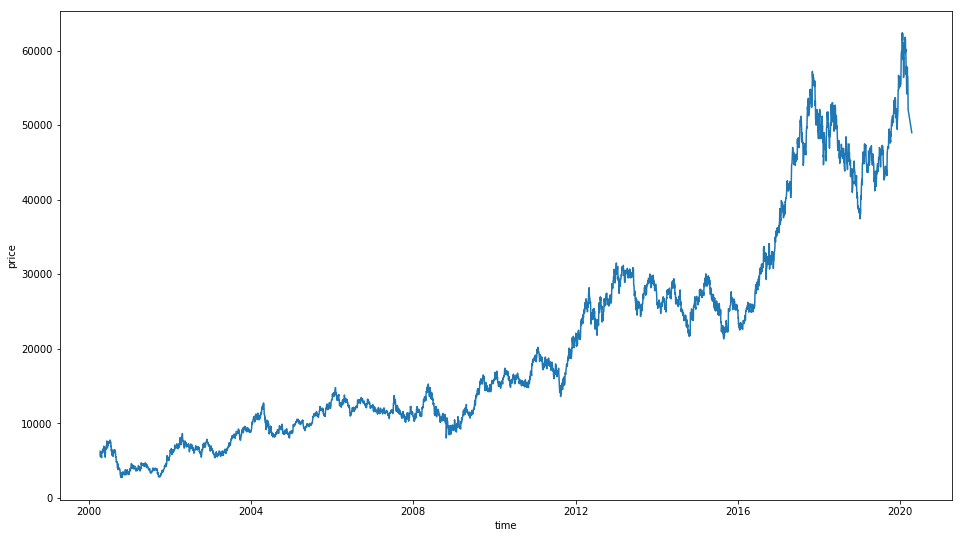

In [3]:
df = df_price.loc[df_price['Year']>=1990]

plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df['Date'])
plt.xlabel('time')
plt.ylabel('price')

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols
df_scaled.dropna(inplace=True)
print(df_scaled)

          Open      High       Low     Close    Volume
0     0.068281  0.065290  0.064777  0.059159  0.379777
1     0.048436  0.049800  0.049258  0.046757  0.475292
2     0.061554  0.057961  0.058030  0.055472  0.448985
3     0.063236  0.061626  0.058030  0.054801  0.369120
4     0.057518  0.056629  0.059042  0.055137  0.227354
5     0.059199  0.056962  0.059885  0.055639  0.160917
6     0.057686  0.054464  0.056343  0.051450  0.169473
7     0.051800  0.049967  0.052294  0.048768  0.212526
8     0.055163  0.051632  0.053644  0.048098  0.239260
9     0.050118  0.048967  0.050270  0.044746  0.329507
10    0.049781  0.055630  0.051282  0.054801  0.459946
11    0.058190  0.053964  0.060391  0.054801  0.000000
12    0.061554  0.062791  0.062416  0.059494  0.440490
13    0.062227  0.058294  0.061910  0.057818  0.161891
14    0.061890  0.059960  0.062753  0.057818  0.158938
15    0.061218  0.056962  0.063428  0.057818  0.000000
16    0.064918  0.065623  0.065452  0.064186  0.320890
17    0.06

In [5]:
TEST_SIZE = 999
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [6]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
#test_feature.shape, test_label.shape
print(train_feature.shape)
# ((180, 20, 4), (180, 1))

(3979, 20, 4)


In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from decimal import Decimal 

model = Sequential()
model.add(LSTM(24, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='tanh', 
               return_sequences=True)
          )
model.add(LSTM(14, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='tanh', 
               return_sequences=True)
          )
model.add(LSTM(8, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='sigmoid', 
               return_sequences=False)
          )
model.add(Dense(1))

Using TensorFlow backend.


In [8]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_path = '/home/inlabws/SY_TEST/keras_lstm/model'
filename = os.path.join(model_path, '20_tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid,y_valid), 
                    callbacks=[early_stop, checkpoint])


Train on 3183 samples, validate on 796 samples
Epoch 1/200
3183/3183 [==============================] - 15s 5ms/step - loss: 0.0041 - val_loss: 2.7913e-04

Epoch 00001: val_loss improved from inf to 0.00028, saving model to /home/inlabws/SY_TEST/keras_lstm/model/20_tmp_checkpoint.h5
Epoch 2/200
3183/3183 [==============================] - 14s 4ms/step - loss: 2.3032e-04 - val_loss: 1.7999e-04

Epoch 00002: val_loss improved from 0.00028 to 0.00018, saving model to /home/inlabws/SY_TEST/keras_lstm/model/20_tmp_checkpoint.h5
Epoch 3/200
3183/3183 [==============================] - 14s 5ms/step - loss: 1.8915e-04 - val_loss: 1.4737e-04

Epoch 00003: val_loss improved from 0.00018 to 0.00015, saving model to /home/inlabws/SY_TEST/keras_lstm/model/20_tmp_checkpoint.h5
Epoch 4/200
3183/3183 [==============================] - 14s 4ms/step - loss: 1.6333e-04 - val_loss: 1.3957e-04

Epoch 00004: val_loss improved from 0.00015 to 0.00014, saving model to /home/inlabws/SY_TEST/keras_lstm/model/2

3183/3183 [==============================] - 14s 4ms/step - loss: 4.6106e-05 - val_loss: 5.9732e-05

Epoch 00039: val_loss did not improve from 0.00004
Epoch 40/200
3183/3183 [==============================] - 14s 4ms/step - loss: 5.1215e-05 - val_loss: 6.1526e-05

Epoch 00040: val_loss did not improve from 0.00004
Epoch 41/200
3183/3183 [==============================] - 14s 4ms/step - loss: 5.1395e-05 - val_loss: 5.1113e-05

Epoch 00041: val_loss did not improve from 0.00004
Epoch 42/200
3183/3183 [==============================] - 14s 4ms/step - loss: 4.3291e-05 - val_loss: 4.2746e-05

Epoch 00042: val_loss did not improve from 0.00004


In [9]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

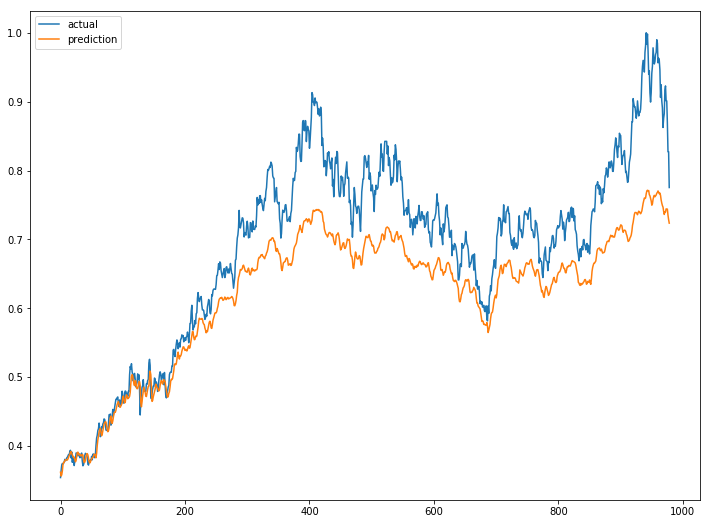

In [10]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()